Final Project Submission
Please fill out:

Student name: Dhruv Ragunathan
Student pace: part time
Scheduled project review date/time:
Instructor name: Mark Barbour
Blog post URL:

# Background

Pneumonia is an infection that inflames the lungs from many potential vectors: Bacteria, Viruses, Fungi, etc. Pneumonia is a potentially fatal infection, that if not identified early on could put the patient's life at risk especially in acute-care settings.

Data sets off lungs with Pneumonia and healthy lungs were provided by Guangzhou Women and Children’s Medical Center, Guangzhou. 


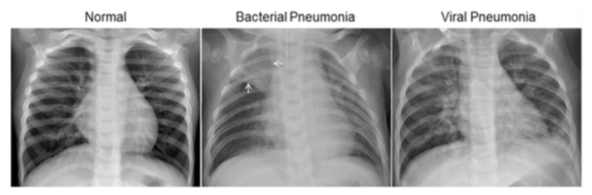


Figure S6. Illustrative Examples of Chest X-Rays in Patients with Pneumonia, Related to Figure 6
The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

# Business Objectives

The goal is to create a model that accurately predicts if an X-ray of a lung has pneumonia. The model will optimize on accuracy because we can save lives by accurately predicting lungs that have pneumonia.

The model will be deployed in a hospital where time is critical. Identifying someone who has pneumonia hours before complications occur can save lives.

This might mean that false positives are identified, scenarios where the model predicted that an x-ray has pneumonia when it really did not. This is ok in the business context because hospital staff can view other symptoms or other lab data to confirm if pnemonia is present or not.


# Data Exploration

Data contains 3 data sets, train, test, and validation.
First separate them out based on whether they are normal or have pneumonia.



In [3]:
# Import data sets

import os, shutil
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
import seaborn as sns
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
np.random.seed(42)

In [28]:
folders = {}
train = {}
test = {}
test = {}
val = {}

main_folder = "chest_xray/"

train_folder = "chest_xray/train"
train_P = "chest_xray/train/PNEUMONIA"
train_N = "chest_xray/train/NORMAL"

test_folder = "chest_xray/test/"
test_P = "chest_xray/test/PNEUMONIA"
test_N = "chest_xray/test/NORMAL"

val_folder = "chest_xray/val/"
val_P = "chest_xray/val/PNEUMONIA"
val_N = "chest_xray/val/NORMAL"


pneu_folds = [train_P,test_P,val_P] #put all pneumonia file paths in one list

normal_folds = [train_N,test_N,val_N] #Put all normal file paths in one list

all_folds = [pneu_folds,normal_folds]




In [33]:
"""

The code below looks at all the file paths. It counts the number of images in each file path and determines
the total number of images with pneumonia or that are normal.

""" 



total_normal = 0
total_pneumonia = 0

total_train_P = 0
total_train_N = 0

total_test_P = 0
total_test_N = 0

total_val_P = 0
total_val_N = 0

for folder in all_folds:
    
    for data_set in folder:
        
        files = data_set.split("/")
        
        if files[2] == 'PNEUMONIA':
            
            num_imgs = len([file for file in os.listdir(data_set) if file.endswith('.jpeg')])
            
            total_pneumonia = total_pneumonia + num_imgs
            
            if files[1] == 'train':
                
                total_train_P = num_imgs
                
            if files[1] == 'test':
            
                total_test_P = num_imgs
                
                
            if files[1] == 'val':
            
                total_val_P = num_imgs

            
        if files[2] == 'NORMAL':
            
            num_imgs = len([file for file in os.listdir(data_set) if file.endswith('.jpeg')])
            
            total_normal = total_normal + num_imgs
            
            if files[1] == 'train':
                
                total_train_N = num_imgs
                
            if files[1] == 'test':
            
                total_test_N = num_imgs
                
                
            if files[1] == 'val':
            
                total_val_N = num_imgs
                
                
total_images = total_pneumonia + total_normal




In [34]:
print('There are',total_images, 'images total')

print('There are',total_pneumonia, 'lungs with pneumonia')

print('There are',total_normal, 'lungs without pneumonia')

There are 5856 images total
There are 4273 lungs with pneumonia
There are 1583 lungs without pneumonia


In [37]:
total_train_P
total_train_N

total_test_P
total_test_N

total_val_P
total_val_N


print('In the train data set the split between pneumonia and normal lungs is ',total_train_P,' and ',total_train_N,' respectively.')
print('In the test data set the split between pneumonia and normal lungs is ',total_test_P,' and ',total_test_N,' respectively.')
print('In the train data set the split between pneumonia and normal lungs is ',total_val_P,' and ',total_val_N,' respectively.')

In the train data set the split between pneumonia and normal lungs is  3875  and  1341  respectively.
In the test data set the split between pneumonia and normal lungs is  390  and  234  respectively.
In the train data set the split between pneumonia and normal lungs is  8  and  8  respectively.


In [ ]:
imgs_santa = [file for file in os.listdir(train_P) if file.endswith('.jpeg')]

print('There are', len(imgs_santa), 'santa images')

<BarContainer object of 2 artists>

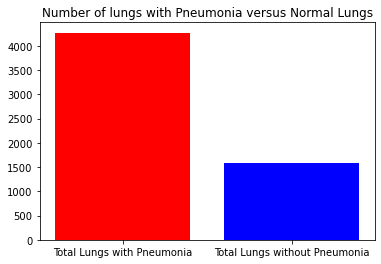

In [38]:
# Visualize total number of infected lungs versus uninfected

plt.title("Number of lungs with Pneumonia versus Normal Lungs")
plt.bar(["Total Lungs with Pneumonia", "Total Lungs without Pneumonia"], [total_pneumonia,total_normal], color = ["r","b"])

The number of lungs with pneumonia is nearly 3 times greater than the number of lungs without.

# Data Preparation

The Process to prepare the data was as follows:
1. First we used Image Data Generator on the images in the test, train, and val data.
2. Then we created the labels indicating if an image has pneumonia or not.

In [9]:
# get all the data in the directory split/test (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
         batch_size = 624) 

# get all the data in the directory split/validation (16 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        batch_size = 16)

# get all the data in the directory split/train (5216 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        batch_size=5216)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [10]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [11]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 256, 256, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 256, 256, 3)
test_labels shape: (624, 2)
val_images shape: (16, 256, 256, 3)
val_labels shape: (16, 2)


In [12]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 196608)
(624, 196608)
(16, 196608)


In [13]:
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

In [14]:
# combine three original datasets into one for data and labels
X = np.concatenate((train_images, test_images, val_images))
y = np.concatenate((train_y, test_y, val_y))

In [15]:
# total dataset size
X.shape

(5856, 256, 256, 3)

### Lets preview an image

Let's look at a healthy lung

In [65]:
#We can tell that this is an unhealthy lung because the train_label[0][1] is 1

train_labels[0]


array([0., 1.], dtype=float32)

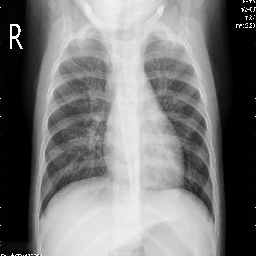

In [66]:

array_to_img(train_images[0])

Let's look at a healthy lung

Now let's look at an unhealthy lung

In [67]:
#We can tell that this is an unhealthy lung because the train_label[0][0] is 1

train_labels[500]

array([1., 0.], dtype=float32)

In [68]:
train_labels[500]

array([1., 0.], dtype=float32)

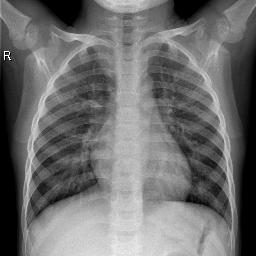

In [69]:
array_to_img(train_images[500])

In [70]:
# Further Explore Dataset

m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 256, 256, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 256, 256, 3)
test_labels shape: (624, 2)
val_images shape: (16, 256, 256, 3)
val_labels shape: (16, 2)


In [71]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 196608)
(624, 196608)
(16, 196608)


In [72]:
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

# Build Baseline Model

The baseline model was built from a a Dense layer network with relu activations using Keras

This model was created iteratively. Previous versions were not saved in this notebook, but the one below was one off the more effective parameters used.

The baseline model used 40 units in the first layer, 20 in the second layer, 10 in the third, all with relu activations.

The baseline model achieved a 95% accuracy on the training data and an 80% accuracy on the testing data.

In [107]:
# Build a baseline fully connected model
model_base = models.Sequential()
model_base.add(layers.Dense(45, activation='relu', input_shape=(196608,))) # 2 hidden layers
model_base.add(layers.Dense(20, activation='relu'))
model_base.add(layers.Dense(10, activation='relu'))
model_base.add(layers.Dense(1, activation='sigmoid'))

In [108]:
model_base.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_base.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
163/163 [==============================] - 23s 141ms/step - loss: 0.7084 - accuracy: 0.7377 - val_loss: 0.7055 - val_accuracy: 0.5000
Epoch 2/50
 39/163 [======>.......................] - ETA: 12s - loss: 0.6209 - accuracy: 0.7516

KeyboardInterrupt: 

In [83]:
results_train = model_base.evaluate(train_img, train_y)

163/163 [==============================] - 3s 17ms/step - loss: 0.1317 - accuracy: 0.9502


In [84]:
results_test = model_base.evaluate(test_img, test_y)

20/20 [==============================] - 1s 64ms/step - loss: 0.6757 - accuracy: 0.8029


In [85]:
results_train

[0.1317339539527893, 0.9501533508300781]

In [86]:
results_test

[0.6756917834281921, 0.8028846383094788]

This model has achieved a 95% accuracy on the training data set and an 80% accuracy on the testing data set.

In [91]:
model_base.history

There is likely some overfitting here due to the training accuracy being higher than the test accuracy.

In [123]:
import pickle

## Convolution Neural Networks

Let's introduce a convulution layer to our network. 

* For a baseline Convulution model, let's use one convulution layer.
* Next we added two more convulution and pooling layers and increased the neurons in the dense layer
* Now we need to reduce overfitting.

In [ ]:
"""

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])



"""

In [104]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [105]:
history = model.fit(train_images,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(test_images, test_y))

Epoch 1/30
163/163 [==============================] - 210s 1s/step - loss: 0.5493 - acc: 0.7379 - val_loss: 0.6284 - val_acc: 0.6250
Epoch 2/30
163/163 [==============================] - 161s 986ms/step - loss: 0.3678 - acc: 0.8165 - val_loss: 0.4607 - val_acc: 0.8013
Epoch 3/30
163/163 [==============================] - 170s 1s/step - loss: 0.3068 - acc: 0.8947 - val_loss: 0.5397 - val_acc: 0.7724
Epoch 4/30
163/163 [==============================] - 165s 1s/step - loss: 0.2586 - acc: 0.9229 - val_loss: 0.7926 - val_acc: 0.7083
Epoch 5/30
163/163 [==============================] - 160s 981ms/step - loss: 0.2332 - acc: 0.9321 - val_loss: 0.5999 - val_acc: 0.7724
Epoch 6/30
163/163 [==============================] - 166s 1s/step - loss: 0.2262 - acc: 0.9329 - val_loss: 1.0300 - val_acc: 0.7131
Epoch 7/30
163/163 [==============================] - 159s 976ms/step - loss: 0.2070 - acc: 0.9392 - val_loss: 0.7836 - val_acc: 0.7548
Epoch 8/30
163/163 [==============================] - 194s 1

In [113]:
conv_results_train_1 = model.evaluate(train_images, train_y)

163/163 [==============================] - 71s 434ms/step - loss: 0.0402 - acc: 0.9870


In [111]:
conv_results_test_1 = model.evaluate(test_images, test_y)

20/20 [==============================] - 7s 343ms/step - loss: 0.9803 - acc: 0.7853


In [114]:
conv_results_val_1 = model.evaluate(val_images, val_y)

1/1 [==============================] - 0s 4ms/step - loss: 0.2034 - acc: 0.9375


This model has achieved a ~99% accuracy on the training data set and an 79% accuracy on the testing data set.

The model is overfit here due to the training accuracy being significantly than the test accuracy.

In [ ]:
## Convolution Neural Networks - Regularization
* First Adding a dropout layer

In [116]:

model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Dropout(0.3))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(40, activation='relu'))
model_2.add(layers.Dropout(0.3))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])



In [117]:
history = model_2.fit(train_images,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(test_images, test_y))

Epoch 1/30
163/163 [==============================] - 233s 1s/step - loss: 0.5007 - acc: 0.7617 - val_loss: 0.4531 - val_acc: 0.7901
Epoch 2/30
163/163 [==============================] - 168s 1s/step - loss: 0.3959 - acc: 0.8050 - val_loss: 0.4913 - val_acc: 0.7532
Epoch 3/30
163/163 [==============================] - 168s 1s/step - loss: 0.3002 - acc: 0.8462 - val_loss: 0.4172 - val_acc: 0.7997
Epoch 4/30
163/163 [==============================] - 171s 1s/step - loss: 0.2626 - acc: 0.8589 - val_loss: 0.8794 - val_acc: 0.7276
Epoch 5/30
163/163 [==============================] - 170s 1s/step - loss: 0.2205 - acc: 0.8852 - val_loss: 0.4573 - val_acc: 0.8093
Epoch 6/30
163/163 [==============================] - 168s 1s/step - loss: 0.1993 - acc: 0.9201 - val_loss: 1.1210 - val_acc: 0.7083
Epoch 7/30
163/163 [==============================] - 167s 1s/step - loss: 0.1827 - acc: 0.9340 - val_loss: 0.9043 - val_acc: 0.7260
Epoch 8/30
163/163 [==============================] - 501s 3s/step - 

In [118]:
conv_results_train_2 = model_2.evaluate(train_images, train_y)

163/163 [==============================] - 61s 374ms/step - loss: 0.0396 - acc: 0.9868


In [120]:
conv_results_test_2 = model_2.evaluate(test_images, test_y)

20/20 [==============================] - 6s 283ms/step - loss: 1.1102 - acc: 0.7708


In [122]:
conv_results_val_2 = model_2.evaluate(val_images, val_y)

1/1 [==============================] - 0s 1ms/step - loss: 0.4347 - acc: 0.7500


In [125]:
pwd

'/Users/dhruvragunathan/Documents/Flatiron/phase_4/Pneumonia_Image_Detection'

In [126]:
model_2.save('/Users/dhruvragunathan/Documents/Flatiron/phase_4/Pneumonia_Image_Detection')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /Users/dhruvragunathan/Documents/Flatiron/phase_4/Pneumonia_Image_Detection/assets
